# Udacity Machine Learning

As described in the previous workbook, the goal of this project is to be able to correctly assign a learn't category from a given users sketch, the training set includes 113 categories, for each 72 available images for learning their features. In this notebook I introduce these features and the extraction process along with some exploration of (what I have called) *feature tuning* i.e. tuning the features to increase performance of classification.

*Once again, the dataset and approach has been taken from the work of Mathias Eitz, James Hays and Marc Alexa, details available http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/*

## Image Pre-Processing

Prior to extracting features from the images, images were first pre-processed - the original images were 1111x1111 PNG's, with varying scales. To mitigate variance in scale, each images padding was cropped out and the image uniformly rescaled to 256x256.

## Feature Extraction - Bag of Visual Words 

In text analysis, an effective approach of classifying a document is by using the concept of Bag of Words (BoWs) where a global dictionary is created including all relevant domain words (also known as tokens and features) then building a vector feature for each document consisting of a count for each word in the document (aka Bag of Words). A model is then trained to identify the frequency of words most applicable for each category e.g. technology realted news may consist of a higher count for the words 'Software' and 'Pivot' than other news categories. 

A similar approach can be taken when classifying images but instead of words being your tokens, you use patch descriptors from your image ie the image is decomposed into a feature vectors for each patch. A global vocabulary is constructed using all the feature vectors extracted from all images then reduced using clustering. The centroids of these clusters become your **visual words** (or **code labels**) of your vocabulary, this vocabulary is known as a **codebook**. 

The **codebook** was created using a batch K-Means clustering algorithm (*sklearn.cluster.MiniBatchKMeans*) - the motivation behind using this (batches) as opposed to KMeans was convergence time due to the high number of clusters (and probably my laptop's computing resources). KMeans method was set to **k-means++** (selects initial cluster centers for k-mean clustering in a smart way to speed up convergence) and batch size (size of the mini batches) was set to **100**.  

The **codebook** (collection of visual words) is then used to build a visual word histograms (**bag of visual words**) as their feature vector for each image (process called *vector quantization*), it is of the premise that this histograms can uniquely describe a category type through a trainned classifier.   

The following figure illustrates the above workflow. 

![alt text](http://drive.google.com/uc?export=view&id=0Bwx_1YjfqdQSUU9Yd05YeDdlVzA "Feature Engineering Workflow")

### Feature Vectors (/Descriptors) 

Feature Vectors (or, as commonly refered to in Computer Vision, Descriptors) are encodings from a patch of a image used to describe some charactersitic of the patch (and collectively the image) i.e. you could describe a patch of a image from it's average RGB (Colour) channels.  

Because sketches are generally sparse in terms of detail, I create a grid of **keypoints**, this to ensure I exctract all meaningful amounts of information from the image.

SIFT (Scale-invariant feature transform) was used to extract the feature vectors (descriptors) from each of the keypoints. *SIFT was created by David Lowe and described fully in his original paper at http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf*.  

The feature vector is built by using a 16x16 patch (centered around each keypoint), this patch is decomposed into 4x4 pixel tiles (x16 tiles for each patch) where for each tile is described as a gradient orientations and magnitude histogram (computed across 8 bins, at 45 degrees). The final result is a **128 bit feature vector** for each keypoint (16x8).  

The following figure illustrates the decomposing of a patch into a 8-bin gradient orientation histogram.  


![alt text](http://drive.google.com/uc?export=view&id=0Bwx_1YjfqdQSVm9HYzNrQW8tWGM "SIFT patch histogram")

## Feature Engineering (Exploration)

In this section I experiment by varying properties used to describe the image - the classification model is held constant (along with the other properties) to observe the influence adjusting each property has on the performance.  

*Admittedly properties are interdependent but given the constraints of time, computing power and patience, this factor was ignored (to some extend).*

**Properties**  
- Influence of training size i.e. is there a point where no more information is gained through samples. 
- Number of cluster (aka visual words) i.e. how many visual words are required to effectively capture all the required information. 
- Window resolution and Window Overlay both have to do with the density of the grid of keyboards i.e. how dense does this grid need to be to capture all necessary information.  

In [6]:
k_accuracy_cols = ["accuracy_at_k{}".format(i) for i in range(1, 11)]

#### Training Size

What influence does the training size have on the performance of our model?  

In [11]:
df = load_trainingsize_df_from_files()

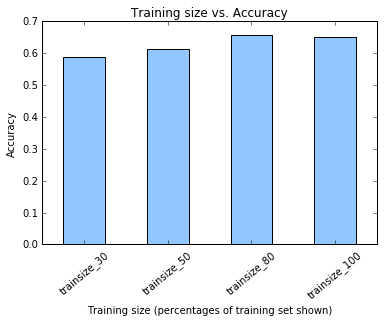

In [103]:
ax = df["accuracy"].plot(kind='bar')
ax.set_title('Training size vs. Accuracy')
ax.set_xlabel('Training size (percentages of training set shown)')
ax.set_ylabel('Accuracy')
_ = ax.set_xticklabels(df.index, rotation=40, ha="center")

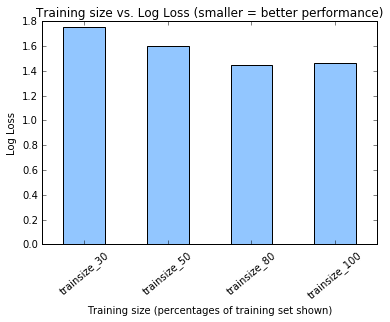

In [104]:
ax = df["log_loss"].plot(kind='bar')
ax.set_title('Training size vs. Log Loss (smaller = better performance)')
ax.set_xlabel('Training size (percentages of training set shown)')
ax.set_ylabel('Log Loss')
_ = ax.set_xticklabels(df.index, rotation=40, ha="center")

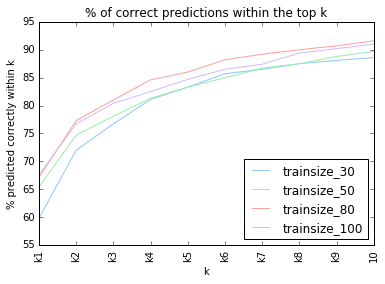

In [161]:
fig, ax = plt.subplots()

figures = []

for i in range(4):
    figures.append(ax.plot(list(df.iloc[i][k_accuracy_cols])))
    
ax.set_title('% of correct predictions within the top k')
ax.set_xlabel('k')
ax.set_ylabel('% predicted correctly within k')
ax.set_xticklabels(map(lambda x: x[-2:], k_accuracy_cols), rotation=90, ha="center")

_ = plt.legend(list(df.index), loc='lower right')

***NB: all subsequent tests are performed with 50% of the training set*** 

### Number of clusters

Clusters in this context is the number of visual words we create for each image feature vector to be assigned to. Similar to compression, the lower the number of clusters the more detail we lose, but possibly gain in generalisation/pattern identification. In this section we vary the number of clusters and compare the performance.  

In [13]:
clusters_df = load_clusters_df_from_files() 

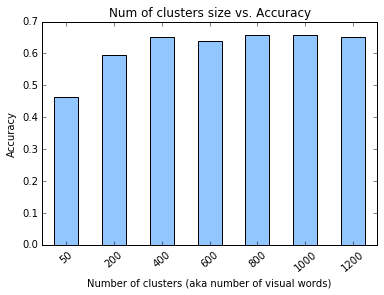

In [165]:
ax = clusters_df["accuracy"].plot(kind='bar')
ax.set_title('Num of clusters size vs. Accuracy')
ax.set_xlabel('Number of clusters (aka number of visual words)')
ax.set_ylabel('Accuracy')
_ = ax.set_xticklabels(clusters_df.index, rotation=40, ha="center")

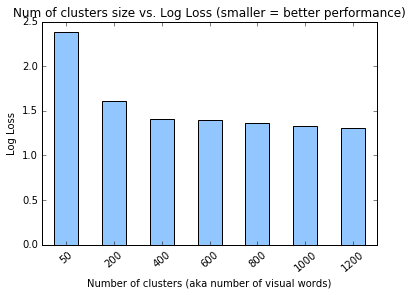

In [167]:
ax = clusters_df["log_loss"].plot(kind='bar')
ax.set_title('Num of clusters size vs. Log Loss (smaller = better performance)')
ax.set_xlabel('Number of clusters (aka number of visual words)')
ax.set_ylabel('Log Loss')
_ = ax.set_xticklabels(clusters_df.index, rotation=40, ha="center")

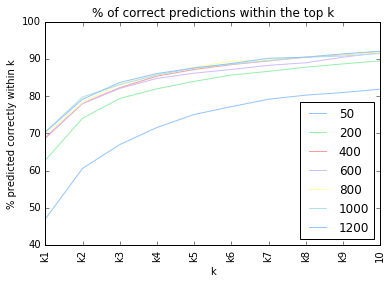

In [169]:
fig, ax = plt.subplots()

figures = []

for i in range(clusters_df.shape[0]):
    figures.append(ax.plot(list(clusters_df.iloc[i][k_accuracy_cols])))    
    
ax.set_title('% of correct predictions within the top k')
ax.set_xlabel('k')
ax.set_ylabel('% predicted correctly within k')
ax.set_xticklabels(map(lambda x: x[-2:], k_accuracy_cols), rotation=90, ha="center")

_ = plt.legend(list(clusters_df.index), loc='lower right')

### Window Resolution

SIFT (and all considered feature extractors) can be confined to a window such to describe segments of the sketches. Here we vary the window size to determine what it's influence has on the performance of our model. 

TODO: elaborate more how window size us used (reference SIFT documentation) 

In [15]:
windowres_df = load_winres_df_from_files()

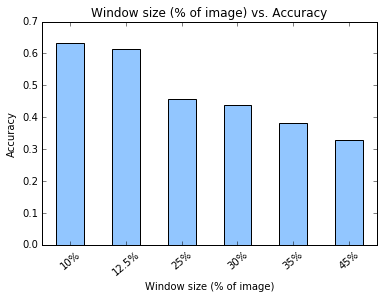

In [172]:
ax = windowres_df["accuracy"].plot(kind='bar')
ax.set_title('Window size (% of image) vs. Accuracy')
ax.set_xlabel('Window size (% of image)')
ax.set_ylabel('Accuracy')
_ = ax.set_xticklabels(windowres_df.index, rotation=40, ha="center")

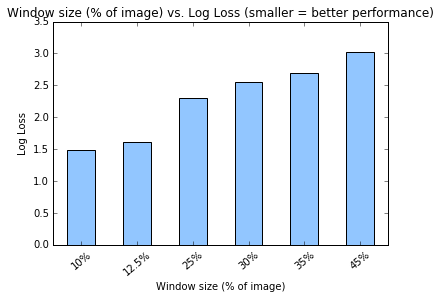

In [173]:
ax = windowres_df["log_loss"].plot(kind='bar')
ax.set_title('Window size (% of image) vs. Log Loss (smaller = better performance)')
ax.set_xlabel('Window size (% of image)')
ax.set_ylabel('Log Loss')
_ = ax.set_xticklabels(windowres_df.index, rotation=40, ha="center")

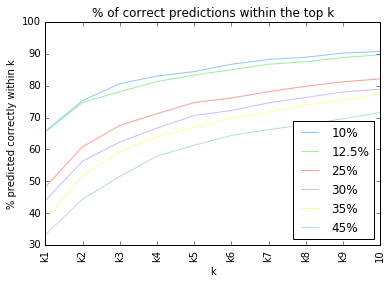

In [174]:
fig, ax = plt.subplots()

figures = []

for i in range(windowres_df.shape[0]):
    figures.append(ax.plot(list(windowres_df.iloc[i][k_accuracy_cols])))    
    
ax.set_title('% of correct predictions within the top k')
ax.set_xlabel('k')
ax.set_ylabel('% predicted correctly within k')
ax.set_xticklabels(map(lambda x: x[-2:], k_accuracy_cols), rotation=90, ha="center")

_ = plt.legend(list(windowres_df.index), loc='lower right')

### Window Overlap

This parameter determines how much overlap there is for each window (or step size 1-1/N where N is the overlap) i.e. N=2 would mean there is a 1/2 overlap between all windows as the window is slide along. 

In [17]:
windowoverlap_df = load_winoverlap_df_from_files()

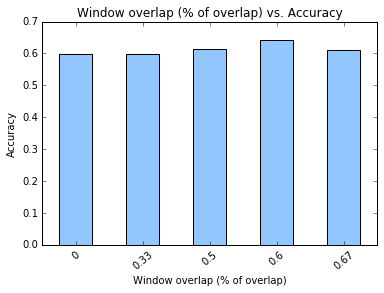

In [177]:
ax = windowoverlap_df["accuracy"].plot(kind='bar')
ax.set_title('Window overlap (% of overlap) vs. Accuracy')
ax.set_xlabel('Window overlap (% of overlap)')
ax.set_ylabel('Accuracy')
_ = ax.set_xticklabels(windowoverlap_df.index, rotation=40, ha="center")

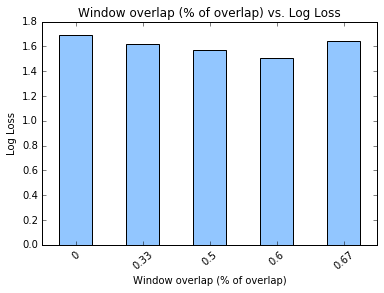

In [178]:
ax = windowoverlap_df["log_loss"].plot(kind='bar')
ax.set_title('Window overlap (% of overlap) vs. Log Loss')
ax.set_xlabel('Window overlap (% of overlap)')
ax.set_ylabel('Log Loss')
_ = ax.set_xticklabels(windowoverlap_df.index, rotation=40, ha="center")

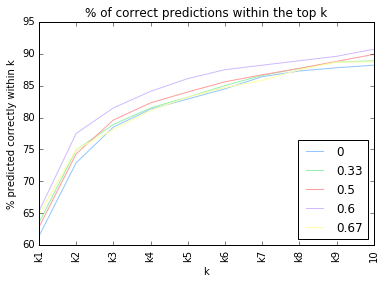

In [179]:
fig, ax = plt.subplots()

figures = []

for i in range(windowoverlap_df.shape[0]):
    figures.append(ax.plot(list(windowoverlap_df.iloc[i][k_accuracy_cols])))    
    
ax.set_title('% of correct predictions within the top k')
ax.set_xlabel('k')
ax.set_ylabel('% predicted correctly within k')
ax.set_xticklabels(map(lambda x: x[-2:], k_accuracy_cols), rotation=90, ha="center")

_ = plt.legend(list(windowoverlap_df.index), loc='lower right')

## Remarks

In regards to **training size**, as expected, the more training data available increases the performance, up to a point - appears to plateau around 80% - this could mean the additional extracted features don't add any more information or that the other parameters of our training are limiting the models ability to learn these additional features.  

The number of **clusters (visual words)** beyond 400 resulted in marginal performance gains, for this reason and to keep things as simple as possible, a visual word dictionary of approx. 500 will be chosen.  

Increasing **window size** reduced performance significantly, possibly loosing to much detail of the sketches. A window size of around 10-12.5% appears to give optimal results but obviously incurs additional computational cost.  

Our last property we explored for extracting features was **window overlap** i.e. what stride was taken for each iteration. The result have shown that an overlap of approx. 60% provide optimal results, similar to **window size**, this adds to the computing overhead.  

Based on the above results, the feature properties moving forwards will be:  
- Use the full training dataset during training 
- 450 visual words when creating the codebook
- Window size of 12.5%
- Overlap of 60% 

---

## Appendix

### Helper methods 

In [7]:
from IPython.core.display import HTML
import pandas as pd 
import numpy as np
import time 
import matplotlib.pyplot as plt
import json

%matplotlib inline
plt.style.use('seaborn-pastel')

/Users/josh/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
def load_results_from_files(filenames, features):
    import os 
    root_folder = "../sketchrecognition/results/feature_engineering_tuning/"
    
    results_list = []
    
    for j in range(len(features)):
        feature = features[j] 
        filename = filenames[j]
        
        with open(root_folder + filename, "r") as f:
            results = json.load(f)
            
            results_dict = {
                "id": feature, 
                "accuracy": float(results["accuracy_score"]), 
                "log_loss": float(results["log_loss"])                
            }
            k_prediction_perc_array = results["k_prediction_perc"]
            for i in range(len(k_prediction_perc_array)):
                results_dict["accuracy_at_k{}".format(i+1)] = float(k_prediction_perc_array[i])
                
            results_list.append(results_dict)
            
    df = pd.DataFrame(results_list)     
    df.set_index("id", inplace=True)
            
    return df

In [10]:
def load_trainingsize_df_from_files():
    return load_results_from_files(
        [                
            "results_extractor-sift_clusters-500_winratio-0.125_trainingsize-2373_classes-113_features-324_201607101422.json", 
            "results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324.json", 
            "results_extractor-sift_clusters-500_winratio-0.125_trainingsize-6441_classes-113_features-324.json", 
            "results_extractor-sift_clusters-500_winratio-0.125_trainingsize-8136_classes-113_features-324.json"
        ], 
        [
            "trainsize_30", 
            "trainsize_50", 
            "trainsize_80", 
            "trainsize_100" 
        ]
    )        

In [12]:
def load_clusters_df_from_files():
    return load_results_from_files(
        [                
            "results_extractor-sift_clusters-50_winratio-0.125_trainingsize-8136_classes-113_features-324_201607101535.json", 
            "results_extractor-sift_clusters-200_winratio-0.125_trainingsize-8136_classes-113_features-324_201607101656.json", 
            "results_extractor-sift_clusters-400_winratio-0.125_trainingsize-8136_classes-113_features-324_201607101927.json", 
            "results_extractor-sift_clusters-600_winratio-0.125_trainingsize-8136_classes-113_features-324_201607102146.json", 
            "results_extractor-sift_clusters-800_winratio-0.125_trainingsize-8136_classes-113_features-324_201607110908.json", 
            "results_extractor-sift_clusters-1000_winratio-0.125_trainingsize-8136_classes-113_features-324_201607110929.json", 
            "results_extractor-sift_clusters-1200_winratio-0.125_trainingsize-8136_classes-113_features-324_201607111305.json"
        ], 
        [
            "50", 
            "200", 
            "400", 
            "600", 
            "800",
            "1000", 
            "1200"
        ]
    )

In [14]:
def load_winres_df_from_files():
    return load_results_from_files(
        [                
            "results_extractor-sift_clusters-500_winratio-0.1_trainingsize-4068_classes-113_features-324_201607112037.json", 
            "results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324_201607112041.json", 
            "results_extractor-sift_clusters-500_winratio-0.25_trainingsize-4068_classes-113_features-324_201607112058.json", 
            "results_extractor-sift_clusters-500_winratio-0.3_trainingsize-4068_classes-113_features-324_201607112112.json", 
            "results_extractor-sift_clusters-500_winratio-0.35_trainingsize-4068_classes-113_features-324_201607112122.json", 
            "results_extractor-sift_clusters-500_winratio-0.45_trainingsize-4068_classes-113_features-324_201607112131.json"
        ], 
        [
            "10%", 
            "12.5%", 
            "25%", 
            "30%", 
            "35%",
            "45%"
        ]
    )

In [16]:
def load_winoverlap_df_from_files():
    return load_results_from_files(
        [                
            "winoverlap-1.0_results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324_201607132225.json", 
            "winoverlap-1.5_results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324_201607132249.json", 
            "winoverlap-2.0_results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324_201607132327.json", 
            "winoverlap-2.5_results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324_201607140032.json", 
            "winoverlap-3.0_results_extractor-sift_clusters-500_winratio-0.125_trainingsize-4068_classes-113_features-324_201607140203.json" 
        ], 
        [
            "0", 
            "0.33", 
            "0.5", 
            "0.6", 
            "0.67"
        ]
    )